In [1]:
!pip3 install -q evaluate transformers datasets mlflow

You should consider upgrading via the '/Users/giovannilonia/Desktop/Tesi/ViT/ViT_env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip3 install accelerate -U

You should consider upgrading via the '/Users/giovannilonia/Desktop/Tesi/ViT/ViT_env/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# imports
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments, 
                          Trainer, 
                          ViTImageProcessor, 
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

Load and preprocess data

5856 5856


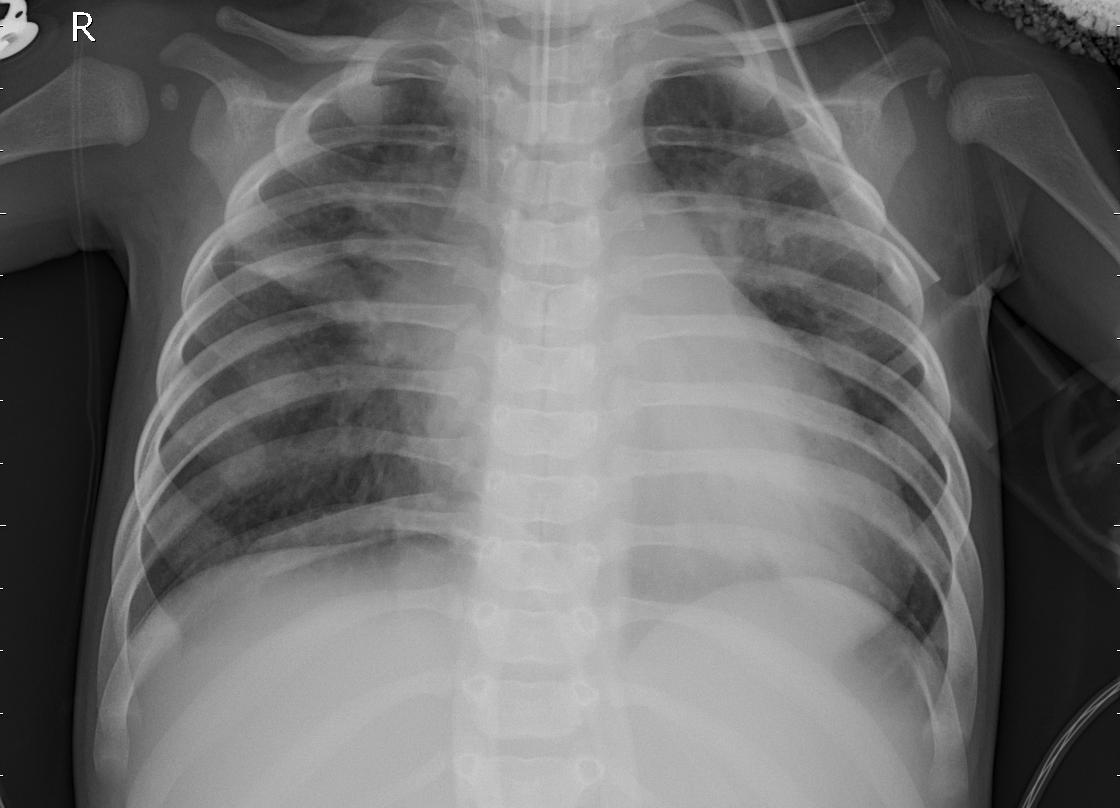

In [4]:
# use https://huggingface.co/docs/datasets/image_load for reference

image_dict = {}
# Define the list of file names
from pathlib import Path
file_names = []
labels = []
for file in Path('./chest_xray').glob('*/*/*.jpeg'):
    file_names.append(str(file))
    label = str(file).split('/')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[0]["image"]

In [5]:
labels_list = ['NORMAL', 'PNEUMONIA']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'NORMAL', 1: 'PNEUMONIA'} 

 {'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5856
})

In [7]:
dataset = dataset.train_test_split(test_size=0.15)
train_data = dataset['train']
test_data = dataset['test']

In [8]:
train_data[2]['label']

'PNEUMONIA'

In [9]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [10]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [11]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Load Model

In [12]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [13]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    
    return {
        "accuracy": acc_score
    }

In [14]:
metric_name = "accuracy"
model_name = "chest_xray_pneumonia_detection"
num_train_epochs=2
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [16]:
trainer.evaluate()

100%|██████████| 220/220 [00:38<00:00,  5.79it/s]


{'eval_loss': 0.7467477321624756,
 'eval_accuracy': 0.23321956769055746,
 'eval_runtime': 40.5441,
 'eval_samples_per_second': 21.68,
 'eval_steps_per_second': 5.426}

In [17]:
trainer.train()

                                                 
 50%|█████     | 156/312 [04:15<04:12,  1.62s/it]

{'eval_loss': 0.21217180788516998, 'eval_accuracy': 0.926052332195677, 'eval_runtime': 19.2961, 'eval_samples_per_second': 45.553, 'eval_steps_per_second': 11.401, 'epoch': 1.0}


100%|██████████| 312/312 [08:24<00:00,  1.22s/it]

{'eval_loss': 0.13243289291858673, 'eval_accuracy': 0.9635949943117179, 'eval_runtime': 19.3197, 'eval_samples_per_second': 45.498, 'eval_steps_per_second': 11.387, 'epoch': 2.0}


100%|██████████| 312/312 [08:28<00:00,  1.63s/it]

{'train_runtime': 508.1698, 'train_samples_per_second': 19.588, 'train_steps_per_second': 0.614, 'train_loss': 0.259647956261268, 'epoch': 2.0}


TrainOutput(global_step=312, training_loss=0.259647956261268, metrics={'train_runtime': 508.1698, 'train_samples_per_second': 19.588, 'train_steps_per_second': 0.614, 'train_loss': 0.259647956261268, 'epoch': 2.0})

In [18]:
trainer.evaluate()

100%|██████████| 220/220 [00:19<00:00, 11.48it/s]


{'eval_loss': 0.13243289291858673,
 'eval_accuracy': 0.9635949943117179,
 'eval_runtime': 19.7712,
 'eval_samples_per_second': 44.459,
 'eval_steps_per_second': 11.127,
 'epoch': 2.0}

In [19]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

100%|██████████| 220/220 [00:19<00:00, 11.57it/s]

{'test_loss': 0.13243289291858673, 'test_accuracy': 0.9635949943117179, 'test_runtime': 19.1644, 'test_samples_per_second': 45.866, 'test_steps_per_second': 11.48}


In [20]:
%matplotlib inline

Accuracy: 0.9636
F1 Score: 0.9759


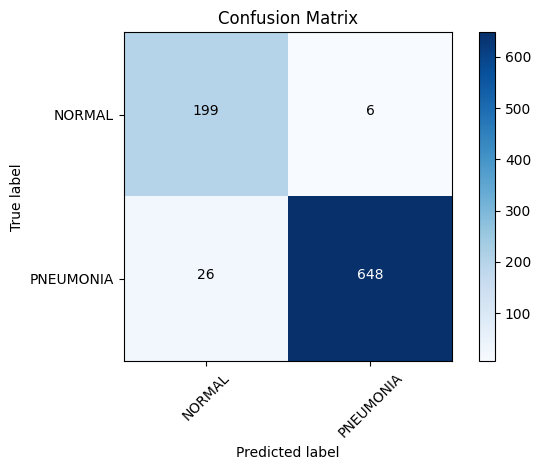

In [21]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    
    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels_list)